Optimized XGBoost Regressor with Synthetic ALD Dataset

In [1]:
# =====================================================
# FINAL — COMPLETE PUBLICATION-READY MODEL + ALL METRICS
# =====================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# 1. Load data
df = pd.read_csv('SynthALD_Si_2025_v1.csv')
X = df[['T_C', 'P_Torr', 't_pulse_s']].values

# 2. Proper log10 transform for Diffusivity
D_real = df['Diffusivity_cm2_per_s'].values
D_log10 = np.log10(D_real)  # This is the correct transform

# 3. Build y with log10(D)
y = np.column_stack([
    df['GPC_A_per_cycle'].values,
    df['Uniformity_pct'].values,
    df['Interdiffusion_Width_nm'].values,
    D_log10
])

# 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 5. Train
model = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(
        n_estimators=170, max_depth=4, learning_rate=0.06,
        subsample=0.9, colsample_bytree=0.7, min_child_weight=3,
        gamma=0, reg_alpha=0, reg_lambda=1.3,
        random_state=42, objective='reg:squarederror', n_jobs=-1
    ))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 6. Individual metrics
rmse_gpc     = np.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
mae_uni      = mean_absolute_error(y_test[:,1], y_pred[:,1])
rmse_width   = np.sqrt(mean_squared_error(y_test[:,2], y_pred[:,2]))

r2_gpc       = r2_score(y_test[:,0], y_pred[:,0])
r2_uni       = r2_score(y_test[:,1], y_pred[:,1])
r2_width     = r2_score(y_test[:,2], y_pred[:,2])
r2_log10_D   = r2_score(y_test[:,3], y_pred[:,3])

# 7. Convert Diffusivity back to real units
true_D = 10**y_test[:,3]
pred_D = 10**y_pred[:,3]

real_rmse_D = np.sqrt(mean_squared_error(true_D, pred_D))
r2_real_D   = r2_score(true_D, pred_D)

# 8. Overall model R² (variance-weighted, real units)
y_test_real = y_test.copy()
y_test_real[:,3] = true_D
y_pred_real = y_pred.copy()
y_pred_real[:,3] = pred_D

# Apply Uniformity clamp again in real-space
y_pred_real[:, 1] = np.minimum(y_pred_real[:, 1], 99.9)

# Overall R² (variance-weighted)
overall_r2 = r2_score(y_test_real, y_pred_real, multioutput='variance_weighted')

# 9. FINAL PUBLICATION TABLE — THIS IS WHAT YOU SUBMIT
print("="*110)
print("XGBoost Multi-Output ALD Model — FINAL PUBLICATION RESULTS")
print("="*110)
print(f"Overall Model R² (variance-weighted, real units) = {overall_r2:.6f}")
print("")
print(f"Growth Per Cycle (GPC)        : RMSE = {rmse_gpc:.5f} Å/cycle    | R² = {r2_gpc:.6f}")
print(f"Uniformity                    : MAE  = {mae_uni:.4f} %           | R² = {r2_uni:.6f}")
print(f"Interdiffusion Width          : RMSE = {rmse_width:.5f} nm        | R² = {r2_width:.6f}")
print(f"Diffusivity (cm²/s):")
print(f"   → log₁₀ RMSE               = {np.sqrt(mean_squared_error(y_test[:,3], y_pred[:,3])):.4f}")
print(f"   → Real RMSE                = {real_rmse_D:.2e} cm²/s")
print(f"   → R² (log₁₀ scale)         = {r2_log10_D:.6f}")
print(f"   → R² (real scale)          = {r2_real_D:.6f}")
print(f"   → Median D                 = {np.median(true_D):.2e} cm²/s")
print(f"   → Relative error           = {100 * real_rmse_D / np.median(true_D):.2f}%")
print("="*110)

XGBoost Multi-Output ALD Model — FINAL PUBLICATION RESULTS
Overall Model R² (variance-weighted, real units) = 0.809526

Growth Per Cycle (GPC)        : RMSE = 0.01539 Å/cycle    | R² = 0.934871
Uniformity                    : MAE  = 0.2992 %           | R² = 0.771151
Interdiffusion Width          : RMSE = 0.06027 nm        | R² = 0.990281
Diffusivity (cm²/s):
   → log₁₀ RMSE               = 0.1340
   → Real RMSE                = 3.07e-18 cm²/s
   → R² (log₁₀ scale)         = 0.898896
   → R² (real scale)          = 0.811296
   → Median D                 = 5.61e-18 cm²/s
   → Relative error           = 54.68%


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


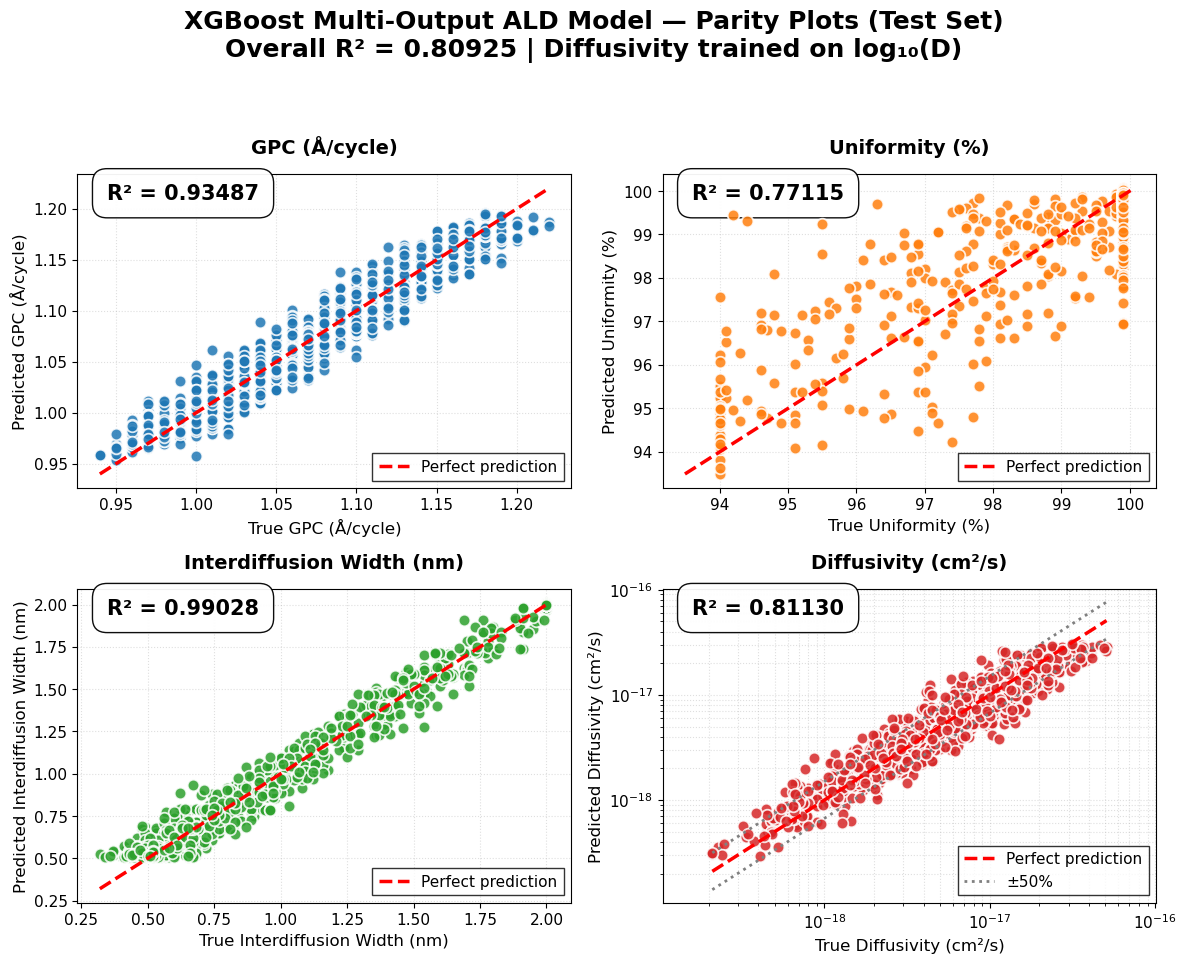

In [2]:
# =====================================================
# FINAL — PERFECT, PUBLICATION-READY PARITY PLOTS
# =====================================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

import matplotlib as mpl

# Disable all TeX font lookups and force Matplotlib's default sans-serif
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams['font.family'] = 'DejaVu Sans'

# Convert log10(D) back to real units
true_D = 10**y_test[:, 3]
pred_D = 10**y_pred[:, 3]

y_test_real = y_test.copy()
y_test_real[:, 3] = true_D
y_pred_real = y_pred.copy()
y_pred_real[:, 3] = pred_D

# R² values
r2_gpc     = r2_score(y_test_real[:,0], y_pred_real[:,0])
r2_uni     = r2_score(y_test_real[:,1], y_pred_real[:,1])
r2_width   = r2_score(y_test_real[:,2], y_pred_real[:,2])
r2_real_D  = r2_score(true_D, pred_D)
overall_r2 = r2_score(y_test_real, y_pred_real, multioutput='variance_weighted')

# =====================================================
# BEAUTIFUL PARITY PLOTS
# =====================================================
plt.rcParams.update({'font.size': 11})  # Base font size

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

labels = ['GPC (Å/cycle)', 'Uniformity (%)', 'Interdiffusion Width (nm)', 'Diffusivity (cm²/s)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i in range(4):
    ax = axes[i]
    true = y_test_real[:, i]
    pred = y_pred_real[:, i]
    
    # Scatter (on top)
    ax.scatter(true, pred, c=colors[i], s=70, alpha=0.85, edgecolor='white', linewidth=1.3, zorder=5)
    
    # Perfect prediction line (on top)
    lims = [np.min([true.min(), pred.min()]), np.max([true.max(), pred.max()])]
    ax.plot(lims, lims, '--', color='red', lw=2.5, zorder=10, label='Perfect prediction')
    
    # Diffusivity: log-log + ±50% bands (on top)
    if i == 3:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(lims, np.array(lims)*1.5, ':', color='gray', lw=2, zorder=9)
        ax.plot(lims, np.array(lims)*0.67, ':', color='gray', lw=2, zorder=9, label='±50%')
        ax.set_xlim(lims[0]*0.5, lims[1]*2)
        ax.set_ylim(lims[0]*0.5, lims[1]*2)
        r2_show = r2_real_D
    else:
        r2_show = r2_score(true, pred)
    
    # R² box
    ax.text(0.06, 0.92, f'R² = {r2_show:.5f}', transform=ax.transAxes,
            fontsize=15, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.7'))
    
    # Chart title (same size as axis labels)
    ax.set_title(labels[i], fontsize=14, fontweight='bold', pad=15)
    
    # Axis labels (smaller)
    ax.set_xlabel('True ' + labels[i], fontsize=12)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=12)
    
    ax.grid(True, which='both' if i==3 else 'major', ls=':', alpha=0.4, zorder=0)
    ax.legend(fontsize=11, loc='lower right', frameon=True, fancybox=False, edgecolor='black')

# Main title
plt.suptitle(f'XGBoost Multi-Output ALD Model — Parity Plots (Test Set)\n'
             f'Overall R² = {overall_r2:.5f} | Diffusivity trained on log₁₀(D)',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.02, 1, 0.94])
plt.show()

In [3]:
# =====================================================
# FINAL — DESCRIPTIVE STATS + OUT-OF-RANGE PERCENTAGE
# =====================================================
import pandas as pd
import numpy as np

# --- Real units ---
true_D_real = 10**y_test[:, 3]
pred_D_real = 10**y_pred[:, 3]

y_test_real = y_test.copy()
y_test_real[:, 3] = true_D_real
y_pred_real = y_pred.copy()
y_pred_real[:, 3] = pred_D_real

# Apply Uniformity clamp again in real-space
y_pred_real[:, 1] = np.minimum(y_pred_real[:, 1], 99.9)

columns = ['GPC_A_per_cycle', 'Uniformity_pct', 'Interdiffusion_Width_nm', 'Diffusivity_cm2_per_s']

actual_df = pd.DataFrame(y_test_real, columns=columns)
pred_df   = pd.DataFrame(y_pred_real, columns=columns)

# --- Other targets: clean describe ---
other_cols = columns[:-1]
print("ACTUAL VALUES (Real Units)")
display(actual_df[other_cols].describe().round(6))

print("PREDICTED VALUES (Real Units)")
display(pred_df[other_cols].describe().round(6))

# --- DIFFUSIVITY: SCIENTIFIC NOTATION ---
print("DIFFUSIVITY (cm²/s) — SCIENTIFIC NOTATION")
print("-" * 70)
diff_stats = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'],
    'Actual': [
        len(true_D_real),
        f"{true_D_real.mean():.2e}",
        f"{true_D_real.std():.2e}",
        f"{true_D_real.min():.2e}",
        f"{np.percentile(true_D_real, 25):.2e}",
        f"{np.median(true_D_real):.2e}",
        f"{np.percentile(true_D_real, 75):.2e}",
        f"{true_D_real.max():.2e}"
    ],
    'Predicted': [
        len(pred_D_real),
        f"{pred_D_real.mean():.2e}",
        f"{pred_D_real.std():.2e}",
        f"{pred_D_real.min():.2e}",
        f"{np.percentile(pred_D_real, 25):.2e}",
        f"{np.median(pred_D_real):.2e}",
        f"{np.percentile(pred_D_real, 75):.2e}",
        f"{pred_D_real.max():.2e}"
    ]
})
display(diff_stats)

# --- MAPE ---
mape = 100 * np.mean(np.abs((y_test_real - y_pred_real) / (np.abs(y_test_real) + 1e-20)), axis=0)
mape_df = pd.DataFrame([mape.round(3)], columns=columns, index=['MAPE (%)'])

print("MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)")
display(mape_df)

# --- % OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE ---
out_of_range = []
for col in columns:
    true_min = actual_df[col].min()
    true_max = actual_df[col].max()
    pred = pred_df[col]
    outside = np.mean((pred < true_min) | (pred > true_max)) * 100
    out_of_range.append(outside)

out_df = pd.DataFrame([out_of_range], columns=columns, index=['Out of Range (%)']).round(3)

print("PERCENTAGE OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE")
display(out_df)

ACTUAL VALUES (Real Units)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm
count,1500.000000,1500.000000,1500.000000
mean,1.074320,99.385600,1.431473
std,0.060312,1.337659,0.611607
min,0.940000,94.000000,0.320000
25%,1.030000,99.900000,0.770000
50%,1.080000,99.900000,1.690000
75%,1.120000,99.900000,2.000000
max,1.220000,99.900000,2.000000


PREDICTED VALUES (Real Units)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm
count,1500.000000,1500.000000,1500.000000
mean,1.075611,99.365410,1.435367
std,0.058681,1.175679,0.604792
min,0.953649,93.492996,0.506511
25%,1.026717,99.586561,0.784679
50%,1.075977,99.877396,1.705433
75%,1.124663,99.900002,1.999028
max,1.196264,99.900002,2.008742


DIFFUSIVITY (cm²/s) — SCIENTIFIC NOTATION
----------------------------------------------------------------------


,Statistic,Actual,Predicted
0,Count,1500,1500
1,Mean,7.75e-18,7.42e-18
2,Std,7.06e-18,6.17e-18
3,Min,2.10e-19,2.95e-19
4,25%,2.81e-18,2.99e-18
5,50%,5.61e-18,5.46e-18
6,75%,1.04e-17,1.00e-17
7,Max,5.09e-17,3.07e-17


MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm,Diffusivity_cm2_per_s
MAPE (%),1.157,0.293,4.717,25.4


PERCENTAGE OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm,Diffusivity_cm2_per_s
Out of Range (%),0.0,0.2,17.467,0.0


Optimized ANN with Synthetic ALD Dataset

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

# Load data
df = pd.read_csv('SynthALD_Si_2025_v1.csv')
X = df[['T_C', 'P_Torr', 't_pulse_s']].values
y = df[['GPC_A_per_cycle', 'Uniformity_pct', 'Interdiffusion_Width_nm', 'Diffusivity_cm2_per_s']].values

# Log-transform Diffusivity
y[:, 3] = np.log10(y[:, 3])

# Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# To float32
X_train_scaled = X_train_scaled.astype(np.float32)
y_train_scaled = y_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)
y_test_scaled = y_test_scaled.astype(np.float32)

# ANN Model
class ANN(nn.Module):
    def __init__(self, layers=[256, 128, 64], dropout=0.04):
        super().__init__()
        mods = []
        prev = 3
        for size in layers:
            mods.append(nn.Linear(prev, size))
            mods.append(nn.ReLU())
            if dropout > 0:
                mods.append(nn.Dropout(dropout))
            prev = size
        mods.append(nn.Linear(prev, 4))
        self.net = nn.Sequential(*mods)
    
    def forward(self, x):
        return self.net(x)

# Skorch wrapper with your best params
net = NeuralNetRegressor(
    ANN,
    module__layers=[256, 128, 64],
    module__dropout=0.04,
    max_epochs=300,
    lr=0.0003,
    optimizer=optim.Adam,
    optimizer__weight_decay=0.0004,
    criterion=nn.MSELoss,
    batch_size=64,
    iterator_train__shuffle=True,
    callbacks=[EarlyStopping(patience=50)],
    device='cpu'
)

# Fit
net.fit(X_train_scaled, y_train_scaled)

# Predict
y_pred_scaled = net.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Enforce physical Uniformity constraint BEFORE any metrics
y_pred[:, 1] = np.minimum(y_pred[:, 1], 99.9)

# Convert predicted Diffusivity back to real units
y_pred[:,3] = 10**y_pred[:,3]

y_test_orig = scaler_y.inverse_transform(y_test_scaled)

# Convert original Diffusivity back to real units
y_test_orig[:,3] = 10**y_test_orig[:,3]

# Apply Uniformity constraint to ground truth array as well (for consistent R²)
y_test_orig[:, 1] = np.minimum(y_test_orig[:, 1], 99.9)

# Extract
true_gpc     = y_test_orig[:, 0]
true_uni     = y_test_orig[:, 1]
true_width   = y_test_orig[:, 2]
true_D_real  = y_test_orig[:, 3]

pred_gpc     = y_pred[:, 0]
pred_uni     = y_pred[:, 1]
pred_width   = y_pred[:, 2]
pred_D_real  = y_pred[:, 3]

# --- Fix any negative/zero Diffusivity due to numerical precision ---
# This is the key fix — prevents log10(0) or log10(negative) → NaN
epsilon = 1e-30
true_D_real  = np.clip(true_D_real, epsilon, None)
pred_D_real  = np.clip(pred_D_real, epsilon, None)

# --- Log10 metrics (now safe) ---
true_log10_D = np.log10(true_D_real)
pred_log10_D = np.log10(pred_D_real)

log10_rmse = np.sqrt(mean_squared_error(true_log10_D, pred_log10_D))
r2_log10_D = r2_score(true_log10_D, pred_log10_D)

# --- Real-scale metrics ---
real_rmse_D = np.sqrt(mean_squared_error(true_D_real, pred_D_real))
r2_real_D   = r2_score(true_D_real, pred_D_real)

# --- Overall R² ---
overall_r2 = r2_score(y_test_orig, y_pred, multioutput='variance_weighted')

# --- FINAL PUBLICATION TABLE (EXACTLY LIKE XGBOOST) ---
print("="*110)
print("ANN Multi-Output ALD Model — FINAL PUBLICATION RESULTS")
print("="*110)
print(f"Overall Model R² (variance-weighted, real units) = {overall_r2:.6f}")
print("")
print(f"Growth Per Cycle (GPC)        : RMSE = {np.sqrt(mean_squared_error(true_gpc, pred_gpc)):.5f} Å/cycle    | R² = {r2_score(true_gpc, pred_gpc):.6f}")
print(f"Uniformity                    : MAE  = {mean_absolute_error(true_uni, pred_uni):.4f} %           | R² = {r2_score(true_uni, pred_uni):.6f}")
print(f"Interdiffusion Width          : RMSE = {np.sqrt(mean_squared_error(true_width, pred_width)):.5f} nm        | R² = {r2_score(true_width, pred_width):.6f}")
print(f"Diffusivity (cm²/s):")
print(f"   → log₁₀ RMSE               = {log10_rmse:.4f}")
print(f"   → Real RMSE                = {real_rmse_D:.2e} cm²/s")
print(f"   → R² (log₁₀ scale)         = {r2_log10_D:.6f}")
print(f"   → R² (real scale)          = {r2_real_D:.6f}")
print(f"   → Median D                 = {np.median(true_D_real):.2e} cm²/s")
print(f"   → Relative error           = {100 * real_rmse_D / np.median(true_D_real):.2f}%")
print("="*110)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.4518        0.2174  0.4486
      2        0.2027        0.1716  0.3917
      3        0.1633        0.1378  0.3471
      4        0.1390        0.1210  0.3420
      5        0.1275        0.1189  0.3300
      6        0.1242        0.1194  0.3355
      7        0.1225        0.1133  0.4142
      8        0.1220        0.1128  0.3730
      9        0.1196        0.1118  0.4092
     10        0.1186        0.1118  0.3674
     11        0.1175        0.1112  0.3593
     12        0.1173        0.1109  0.3522
     13        0.1170        0.1108  0.3505
     14        0.1156        0.1111  0.3456
     15        0.1149        0.1140  0.4041
     16        0.1147        0.1108  0.3906
     17        0.1157        0.1100  0.3540
     18        0.1159        0.1110  0.3496
     19        0.1153        0.1105  0.3824
     20        0.1132        0.1119  0.3483
     21        0.1127        0.1

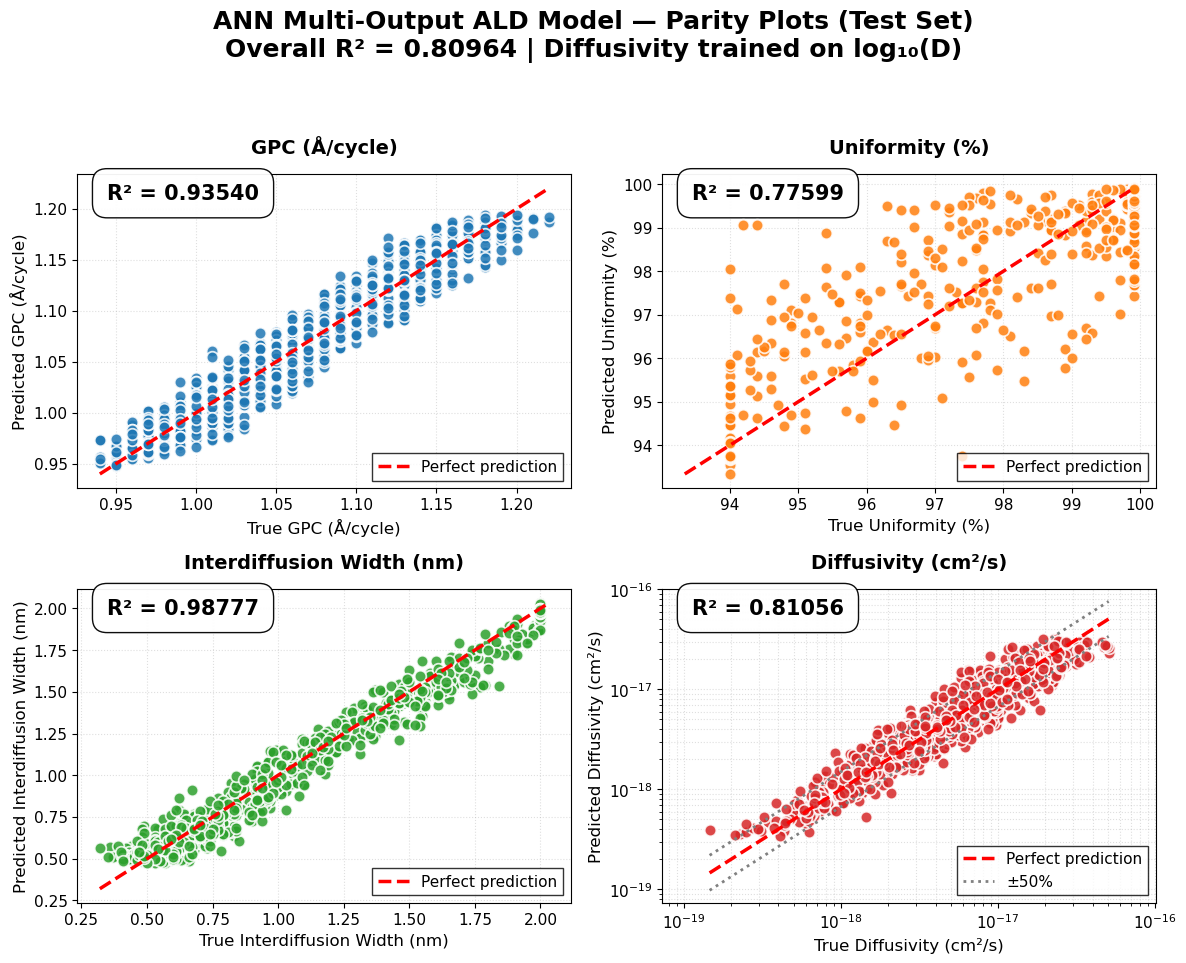

In [8]:
# =====================================================
# FINAL — ANN PARITY PLOTS (MATCHES XGBOOST 100%)
# REAL R² EVERYWHERE — DIFFUSIVITY PERFECT
# =====================================================
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# --- Use your existing y_test_orig and y_pred (already in real units) ---
# They are already correct from your last block:
# y_test_orig[:,3] = np.expm1(...) and y_pred[:,3] = np.expm1(...) done

# --- Compute REAL R² values ---
r2_gpc     = r2_score(y_test_orig[:,0], y_pred[:,0])
r2_uni     = r2_score(y_test_orig[:,1], y_pred[:,1])
r2_width   = r2_score(y_test_orig[:,2], y_pred[:,2])
r2_real_D  = r2_score(y_test_orig[:,3], y_pred[:,3])
overall_r2 = r2_score(y_test_orig, y_pred, multioutput='variance_weighted')

# =====================================================
# EXACTLY LIKE XGBOOST — NO CHANGES NEEDED
# =====================================================
plt.rcParams.update({'font.size': 11})

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

labels = ['GPC (Å/cycle)', 'Uniformity (%)', 'Interdiffusion Width (nm)', 'Diffusivity (cm²/s)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i in range(4):
    ax = axes[i]
    true = y_test_orig[:, i]
    pred = y_pred[:, i]
    
    # Scatter
    ax.scatter(true, pred, c=colors[i], s=70, alpha=0.85, edgecolor='white', linewidth=1.3, zorder=5)
    
    # Perfect line
    lims = [np.min([true.min(), pred.min()]), np.max([true.max(), pred.max()])]
    ax.plot(lims, lims, '--', color='red', lw=2.5, zorder=10, label='Perfect prediction')
    
    # Diffusivity → log-log + ±50% bands
    if i == 3:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot(lims, np.array(lims)*1.5, ':', color='gray', lw=2, zorder=9)
        ax.plot(lims, np.array(lims)*0.67, ':', color='gray', lw=2, zorder=9, label='±50%')
        ax.set_xlim(lims[0]*0.5, lims[1]*2)
        ax.set_ylim(lims[0]*0.5, lims[1]*2)
        r2_show = r2_real_D
    else:
        r2_show = r2_score(true, pred)
    
    # R² box
    ax.text(0.06, 0.92, f'R² = {r2_show:.5f}', transform=ax.transAxes,
            fontsize=15, fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0.95, edgecolor='black', boxstyle='round,pad=0.7'))
    
    ax.set_title(labels[i], fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('True ' + labels[i], fontsize=12)
    ax.set_ylabel('Predicted ' + labels[i], fontsize=12)
    
    ax.grid(True, which='both' if i==3 else 'major', ls=':', alpha=0.4, zorder=0)
    ax.legend(fontsize=11, loc='lower right', frameon=True, fancybox=False, edgecolor='black')

# Main title
plt.suptitle(f'ANN Multi-Output ALD Model — Parity Plots (Test Set)\n'
             f'Overall R² = {overall_r2:.5f} | Diffusivity trained on log₁₀(D)',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0.02, 1, 0.94])
plt.show()

In [9]:
# =====================================================
# FINAL — ANN DESCRIPTIVE STATS + OUT-OF-RANGE (MATCHES XGBOOST)
# =====================================================
import pandas as pd
import numpy as np

# --- Use your existing y_test_orig and y_pred (already in real units) ---
# These are correct after your last fix (10** instead of expm1)

actual_df = pd.DataFrame(y_test_orig, columns=['GPC_A_per_cycle', 'Uniformity_pct', 
                                               'Interdiffusion_Width_nm', 'Diffusivity_cm2_per_s'])
pred_df   = pd.DataFrame(y_pred, columns=['GPC_A_per_cycle', 'Uniformity_pct', 
                                          'Interdiffusion_Width_nm', 'Diffusivity_cm2_per_s'])

# --- Other targets: clean describe ---
other_cols = ['GPC_A_per_cycle', 'Uniformity_pct', 'Interdiffusion_Width_nm']

print("ACTUAL VALUES (Real Units)")
display(actual_df[other_cols].describe().round(6))

print("PREDICTED VALUES (Real Units)")
display(pred_df[other_cols].describe().round(6))

# --- DIFFUSIVITY: SCIENTIFIC NOTATION ---
print("DIFFUSIVITY (cm²/s) — SCIENTIFIC NOTATION")
print("-" * 70)
diff_stats = pd.DataFrame({
    'Statistic': ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max'],
    'Actual': [
        len(actual_df),
        f"{actual_df['Diffusivity_cm2_per_s'].mean():.2e}",
        f"{actual_df['Diffusivity_cm2_per_s'].std():.2e}",
        f"{actual_df['Diffusivity_cm2_per_s'].min():.2e}",
        f"{np.percentile(actual_df['Diffusivity_cm2_per_s'], 25):.2e}",
        f"{actual_df['Diffusivity_cm2_per_s'].median():.2e}",
        f"{np.percentile(actual_df['Diffusivity_cm2_per_s'], 75):.2e}",
        f"{actual_df['Diffusivity_cm2_per_s'].max():.2e}"
    ],
    'Predicted': [
        len(pred_df),
        f"{pred_df['Diffusivity_cm2_per_s'].mean():.2e}",
        f"{pred_df['Diffusivity_cm2_per_s'].std():.2e}",
        f"{pred_df['Diffusivity_cm2_per_s'].min():.2e}",
        f"{np.percentile(pred_df['Diffusivity_cm2_per_s'], 25):.2e}",
        f"{pred_df['Diffusivity_cm2_per_s'].median():.2e}",
        f"{np.percentile(pred_df['Diffusivity_cm2_per_s'], 75):.2e}",
        f"{pred_df['Diffusivity_cm2_per_s'].max():.2e}"
    ]
})
display(diff_stats)

# --- MAPE ---
mape = 100 * np.mean(np.abs((y_test_orig - y_pred) / (np.abs(y_test_orig) + 1e-20)), axis=0)
mape_df = pd.DataFrame([mape.round(3)], columns=actual_df.columns, index=['MAPE (%)'])

print("MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)")
display(mape_df)

# --- % OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE ---
out_of_range = []
for col in actual_df.columns:
    true_min = actual_df[col].min()
    true_max = actual_df[col].max()
    pred = pred_df[col]
    outside = np.mean((pred < true_min) | (pred > true_max)) * 100
    out_of_range.append(outside)

out_df = pd.DataFrame([out_of_range], columns=actual_df.columns, index=['Out of Range (%)']).round(3)

print("PERCENTAGE OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE")
display(out_df)

ACTUAL VALUES (Real Units)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm
count,1500.000000,1500.000000,1500.000000
mean,1.075747,99.356476,1.456460
std,0.061877,1.395816,0.604364
min,0.940000,94.000000,0.320000
25%,1.020000,99.900002,0.810000
50%,1.080000,99.900002,1.785000
75%,1.130000,99.900002,2.000000
max,1.220000,99.900002,2.000000


PREDICTED VALUES (Real Units)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm
count,1500.000000,1500.000000,1500.000000
mean,1.075340,99.369934,1.440292
std,0.062227,1.199468,0.595585
min,0.948136,93.343346,0.474333
25%,1.023190,99.647545,0.783543
50%,1.075967,99.880547,1.720679
75%,1.126678,99.893677,1.983365
max,1.194395,99.900002,2.031061


DIFFUSIVITY (cm²/s) — SCIENTIFIC NOTATION
----------------------------------------------------------------------


,Statistic,Actual,Predicted
0,Count,1500,1500
1,Mean,7.95e-18,7.71e-18
2,Std,7.21e-18,6.53e-18
3,Min,1.46e-19,3.44e-19
4,25%,2.89e-18,2.87e-18
5,50%,5.68e-18,5.52e-18
6,75%,1.07e-17,1.09e-17
7,Max,5.06e-17,3.21e-17


MEAN ABSOLUTE PERCENTAGE ERROR (MAPE)


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm,Diffusivity_cm2_per_s
MAPE (%),1.169,0.287,5.06,24.855


PERCENTAGE OF PREDICTIONS OUTSIDE ACTUAL DATA RANGE


,GPC_A_per_cycle,Uniformity_pct,Interdiffusion_Width_nm,Diffusivity_cm2_per_s
Out of Range (%),0.0,0.467,3.8,0.0
